In [1]:
%matplotlib widget
import os
import sys
import math

# Путь к директории, где находится текущий ноутбук
NOTEBOOK_DIR = os.path.abspath(os.path.dirname("__file__"))  # работает в Jupyter

# Поднимаемся на один уровень вверх – получаем корень проекта
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, os.pardir, 'src'))

# Добавляем корень в начало sys.path, если его там ещё нет
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, Tuple, Set

from OCC.Core.BRep import BRep_Tool
from OCC.Core.BRepMesh import BRepMesh_IncrementalMesh
from OCC.Core.gp import gp_Ax2, gp_Pnt, gp_Vec
from OCC.Core.Poly import Poly_Triangle
from OCC.Core.TopAbs import TopAbs_FACE
from OCC.Core.TopExp import topexp as TopExp, TopExp_Explorer
from OCC.Core.TopTools import TopTools_IndexedMapOfShape
from OCC.Core.TopoDS import TopoDS_Shape, TopoDS_Face, topods_Face, topods
from OCC.Core.TopLoc import TopLoc_Location


@dataclass
class FaceVisibilityResult:
    """
    Результат видимости граней для одного вида.

    Attributes
    ----------
    face_map:
        IndexedMapOfShape, содержащая все грани исходного shape.
        Индексы граней (1..N) используются как face_index.
    visible_faces:
        Множество индексов граней (1..face_map.Extent()), которые считаются
        видимыми на данном виде.
    """

    face_map: TopTools_IndexedMapOfShape
    visible_faces: Set[int]

    def is_face_visible(self, face: TopoDS_Face) -> bool:
        """Проверка видимости конкретной грани по её объекту."""
        idx = self.face_map.FindIndex(face)
        if idx == 0:
            return False
        return idx in self.visible_faces

    def is_index_visible(self, face_index: int) -> bool:
        """Проверка видимости по индексу 1..face_map.Extent()."""
        return face_index in self.visible_faces


@dataclass
class MultiViewFaceVisibility:
    """
    Результат видимости граней для нескольких видов.

    Attributes
    ----------
    face_map:
        Общий IndexedMapOfShape по всем видам (один на исходный shape).
    visible_on_view:
        Словарь view_name -> множество индексов видимых граней на этом виде.
    """

    face_map: TopTools_IndexedMapOfShape
    visible_on_view: Dict[str, Set[int]]

    def views_for_face_index(self, face_index: int) -> Set[str]:
        """
        На каких видах эта грань видима (по индексу)?
        """
        return {name for name, vis in self.visible_on_view.items()
                if face_index in vis}

    def views_for_face(self, face: TopoDS_Face) -> Set[str]:
        """
        На каких видах видна данная грань (по объекту TopoDS_Face)?
        """
        idx = self.face_map.FindIndex(face)
        if idx == 0:
            return set()
        return self.views_for_face_index(idx)


# ---------------------------------------------------------------------------
# Внутренние вспомогательные функции
# ---------------------------------------------------------------------------

def _build_face_map(shape: TopoDS_Shape) -> TopTools_IndexedMapOfShape:
    """
    Строит IndexedMapOfShape для всех граней исходного shape.
    Индексация 1..N.

    Это даёт стабильные целочисленные индексы для границ,
    чтобы не полагаться на hash(face).
    """
    face_map = TopTools_IndexedMapOfShape()
    TopExp.MapShapes(shape, TopAbs_FACE, face_map)
    return face_map


def _project_point_to_view(pnt: gp_Pnt, ax2: gp_Ax2) -> Tuple[float, float, float]:
    """
    Проецирует 3D-точку в координаты системы вида (ξ, η, ζ):

        ξ  — по XDirection(),
        η  — по YDirection(),
        ζ  — по Direction() (ось взгляда).

    ζ используется как "глубина" для z-buffer:
        меньше ζ -> ближе к наблюдателю
    (при условии, что направление взгляда выбрано согласованно).
    """
    origin = ax2.Location()
    vx = gp_Vec(ax2.XDirection())
    vy = gp_Vec(ax2.YDirection())
    vz = gp_Vec(ax2.Direction())

    v = gp_Vec(origin, pnt)
    xi = vx.Dot(v)
    eta = vy.Dot(v)
    zeta = vz.Dot(v)

    return xi, eta, zeta


# ---------------------------------------------------------------------------
# Основной алгоритм z-buffer по триангуляции
# ---------------------------------------------------------------------------

def compute_face_visibility_by_zbuffer(
    shape: TopoDS_Shape,
    view_ax2: gp_Ax2,
    *,
    grid_size: int = 256,
    deflection: float = 5e-4,
    angle: float = 0.5,
) -> FaceVisibilityResult:
    """
    Приближённо определяет, какие грани shape видимы на заданном виде
    (ортогональная проекция в системе координат view_ax2) с помощью
    грубого z-buffer по центрам триангуляции.

    Параметры
    ---------
    shape:
        Исходный TopoDS_Shape (сплошное тело или сборка).
    view_ax2:
        gp_Ax2, задающая систему координат вида:
            Direction()  -> направление взгляда,
            XDirection() -> ось ξ,
            YDirection() -> ось η.
    grid_size:
        Разрешение регулярной сетки в плоскости вида (ξ, η) для z-buffer.
        256..512 обычно достаточно. Чем больше, тем точнее и медленнее.
    deflection:
        Параметр триангуляции (BRepMesh_IncrementalMesh), допуск по отклонению.
    angle:
        Максимальное отклонение нормали в радианах (так же для мезера).

    Возвращает
    ----------
    FaceVisibilityResult:
        - face_map: IndexedMapOfShape (все грани shape).
        - visible_faces: множество индексов видимых граней (1..N).
    """

    # --- 1. Строим карту граней ---
    face_map = _build_face_map(shape)
    nb_faces = face_map.Size()
    if nb_faces == 0:
        return FaceVisibilityResult(face_map=face_map, visible_faces=set())

    # --- 2. Триангулируем shape (если уже триангулирован — OCCT переприведёт как надо) ---
    BRepMesh_IncrementalMesh(shape, deflection, False, angle, True)

    # --- 3. Собираем центры треугольников в координатах вида ---
    tris = []  # список (face_index, xi, eta, zeta)
    xis = []
    etas = []

    # Для корректного получения triangulation учитываем возможные location
    exp = TopExp_Explorer(shape, TopAbs_FACE)
    while exp.More():
        face = topods.Face(exp.Current())
        exp.Next()

        face_index = face_map.FindIndex(face)
        if face_index == 0:
            # На всякий случай, но по идее все грани должны быть в face_map
            continue

        loc = TopLoc_Location()
        tri = BRep_Tool.Triangulation(face, loc)
        if tri is None:
            continue

        nb_tris = tri.NbTriangles()

        # Преобразование по location, если оно задано
        has_loc = not loc.IsIdentity()
        trsf = loc.Transformation() if has_loc else None

        for i_tri in range(1, nb_tris + 1):
            poly_tri: Poly_Triangle = tri.Triangle(i_tri)
            n1, n2, n3 = poly_tri.Get()

            p1 = tri.Node(n1)
            p2 = tri.Node(n2)
            p3 = tri.Node(n3)

            if has_loc:
                p1.Transform(trsf)
                p2.Transform(trsf)
                p3.Transform(trsf)

            cx = (p1.X() + p2.X() + p3.X()) / 3.0
            cy = (p1.Y() + p2.Y() + p3.Y()) / 3.0
            cz = (p1.Z() + p2.Z() + p3.Z()) / 3.0
            pc = gp_Pnt(cx, cy, cz)

            xi, eta, zeta = _project_point_to_view(pc, view_ax2)

            tris.append((face_index, xi, eta, zeta))
            xis.append(xi)
            etas.append(eta)


    if not tris:
        # Ни одной триангулированной грани
        return FaceVisibilityResult(face_map=face_map, visible_faces=set())

    # --- 4. Строим bounding box в (ξ, η) + небольшой паддинг ---
    xi_min, xi_max = min(xis), max(xis)
    eta_min, eta_max = min(etas), max(etas)

    dx = xi_max - xi_min
    dy = eta_max - eta_min
    # защита от вырожденности
    if dx == 0.0:
        dx = 1.0
    if dy == 0.0:
        dy = 1.0

    pad_x = 0.01 * dx
    pad_y = 0.01 * dy

    xi_min -= pad_x
    xi_max += pad_x
    eta_min -= pad_y
    eta_max += pad_y

    # --- 5. Z-buffer: (ix, iy) -> (zeta, face_index) ---
    zbuffer: Dict[Tuple[int, int], Tuple[float, int]] = {}

    def to_grid(xi: float, eta: float) -> Tuple[int, int]:
        gx = (xi - xi_min) / (xi_max - xi_min)
        gy = (eta - eta_min) / (eta_max - eta_min)
        ix = int(gx * (grid_size - 1))
        iy = int(gy * (grid_size - 1))
        # На всякий случай ограничим диапазон
        ix = max(0, min(grid_size - 1, ix))
        iy = max(0, min(grid_size - 1, iy))
        return ix, iy

    for face_index, xi, eta, zeta in tris:
        ix, iy = to_grid(xi, eta)
        key = (ix, iy)

        # Выбираем минимальный zeta как "ближе к наблюдателю"
        if key not in zbuffer:
            zbuffer[key] = (zeta, face_index)
        else:
            z_old, f_old = zbuffer[key]
            if zeta < z_old:
                zbuffer[key] = (zeta, face_index)

    # --- 6. Собираем множество видимых граней ---
    visible_faces: Set[int] = set()
    for (_ix, _iy), (_z, f_index) in zbuffer.items():
        visible_faces.add(f_index)

    return FaceVisibilityResult(face_map=face_map, visible_faces=visible_faces)


def compute_multiview_face_visibility(
    shape: TopoDS_Shape,
    views: Dict[str, gp_Ax2],
    *,
    grid_size: int = 256,
    deflection: float = 5e-4,
    angle: float = 0.5,
) -> MultiViewFaceVisibility:
    """
    Вычисляет видимость граней shape для нескольких видов сразу.

    Параметры
    ---------
    shape:
        Исходный shape.
    views:
        Словарь имя_вида -> gp_Ax2 (система координат вида).
        Например:
            {
              "front": ax2_front,
              "top": ax2_top,
              "side": ax2_side,
            }
    grid_size, deflection, angle:
        Параметры z-buffer и триангуляции (см. compute_face_visibility_by_zbuffer).

    Возвращает
    ----------
    MultiViewFaceVisibility:
        - общий face_map,
        - словарь view_name -> множество видимых индексов граней.
    """

    # Общая карта граней для всех видов
    face_map = _build_face_map(shape)
    visible_on_view: Dict[str, Set[int]] = {}

    for name, ax2 in views.items():
        res = compute_face_visibility_by_zbuffer(
            shape,
            ax2,
            grid_size=grid_size,
            deflection=deflection,
            angle=angle,
        )
        # На всякий случай можно проверить, что res.face_map совместим с нашим face_map,
        # но так как _build_face_map детерминированно, здесь считаем, что он совпадает.
        visible_on_view[name] = res.visible_faces

    return MultiViewFaceVisibility(face_map=face_map, visible_on_view=visible_on_view)

In [3]:
from pathlib import Path
from collections import Counter, defaultdict

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2
from OCC.Core.HLRAlgo import HLRAlgo_Projector
from OCC.Core.HLRBRep import HLRBRep_Algo, HLRBRep_HLRToShape
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE

from OCC.Core.GeomAbs import (
    GeomAbs_Line,
    GeomAbs_Circle,
    GeomAbs_Ellipse,
    GeomAbs_BSplineCurve,
    GeomAbs_BezierCurve,
    GeomAbs_OtherCurve,
)

from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.GCPnts import GCPnts_AbscissaPoint

from afr3d.io.step_import import extract_solids, load_step

step_path = Path("../data/example_complex.stp")
shape_raw = load_step(step_path)
shape = extract_solids(shape_raw)

In [4]:
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_FACE, TopAbs_EDGE

# “Нативный” подсчёт граней из shape
def count_faces_native(shape):
    exp = TopExp_Explorer(shape, TopAbs_FACE)
    n = 0
    while exp.More():
        n += 1
        exp.Next()
    return n

def count_edges_native(shape):
    exp = TopExp_Explorer(shape, TopAbs_EDGE)
    n = 0
    while exp.More():
        n += 1
        exp.Next()
    return n

print("OCCT (native) faces:", count_faces_native(shape))
print("OCCT (native) edges:", count_edges_native(shape))

OCCT (native) faces: 157
OCCT (native) edges: 785


In [ ]:
# 2. Определяем системы координат видов (можно взять из твоего OBB/ориентации)
origin = gp_Pnt(0.0, 0.0, 0.0)

ax2_front = gp_Ax2(origin, gp_Dir(0, 0, -1), gp_Dir(0, 1, 0))  # фронт
ax2_top   = gp_Ax2(origin, gp_Dir(0, -1, 0), gp_Dir(0, 0, -1)) # сверху
ax2_side  = gp_Ax2(origin, gp_Dir(1, 0, 0), gp_Dir(0, 1, 0))   # сбоку

# 3. Один вид
front_vis = compute_face_visibility_by_zbuffer(shape, ax2_front)
print("Видимых граней на front:", len(front_vis.visible_faces))

# 4. Несколько видов
views = {
    "front": ax2_front,
    "top": ax2_top,
    "side": ax2_side,
}
multi_vis = compute_multiview_face_visibility(shape, views)

print("Всего граней:", multi_vis.face_map.Size())
for name, vis in multi_vis.visible_on_view.items():
    print(f"Вид {name}: видимо граней = {len(vis)}")

# 5. Пример: на каких видах видна конкретная грань
# (например, первая грань в карте)
face_index = 1
face = topods.Face(multi_vis.face_map.FindKey(face_index))
print("Грань #1 видна на видах:", multi_vis.views_for_face(face))

видимых граней на front: 153
Всего граней: 157
Вид front: видимо граней = 153
Вид top: видимо граней = 152
Вид side: видимо граней = 150
Грань #1 видна на видах: {'front', 'side', 'top'}


In [9]:
from OCC.Core.gp import gp_Vec, gp_Pnt, gp_Ax2

def project_point_to_view_2d(pnt: gp_Pnt, ax2: gp_Ax2):
    """
    3D → 2D для ГРАНЕЙ: проектируем модель в координаты вида.
    Этим пользуемся только для исходного shape (faces).
    """
    origin = ax2.Location()
    vx = gp_Vec(ax2.XDirection())
    vy = gp_Vec(ax2.YDirection())
    v = gp_Vec(origin, pnt)
    xi = vx.Dot(v)
    eta = vy.Dot(v)
    return xi, eta

from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.GeomAbs import GeomAbs_Line

def sample_face_edge_2d(edge, ax2: gp_Ax2, n_samples: int = 32):
    pts_2d = []
    try:
        bac = BRepAdaptor_Curve(edge)
    except Exception:
        return pts_2d

    try:
        first = bac.FirstParameter()
        last = bac.LastParameter()
    except Exception:
        return pts_2d

    if last <= first:
        return pts_2d

    if bac.GetType() == GeomAbs_Line:
        params = [first, last]
    else:
        params = [first + (last - first) * i / (n_samples - 1) for i in range(n_samples)]

    for u in params:
        try:
            p3d = bac.Value(u)
        except Exception:
            continue

        x, y = project_point_to_view_2d(p3d, ax2)
        pts_2d.append((x, y))

    return pts_2d

def sample_hlr_edge_2d(edge, n_samples: int = 32):
    """
    Семплируем ребро из HLR-shape.

    ВАЖНО:
      HLRBRep_HLRToShape уже выдал рёбра в плоскости проекции,
      поэтому мы просто берём p.X(), p.Y().
    """
    pts_2d = []
    try:
        bac = BRepAdaptor_Curve(edge)
    except Exception:
        return pts_2d

    try:
        first = bac.FirstParameter()
        last = bac.LastParameter()
    except Exception:
        return pts_2d

    if last <= first:
        return pts_2d

    if bac.GetType() == GeomAbs_Line:
        params = [first, last]
    else:
        params = [first + (last - first) * i / (n_samples - 1) for i in range(n_samples)]

    for u in params:
        try:
            p3d = bac.Value(u)
        except Exception:
            continue

        # п3d уже лежит в плоскости вида
        x = p3d.X()
        y = p3d.Y()
        pts_2d.append((x, y))

    return pts_2d

from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE
from OCC.Core.GeomAbs import (
    GeomAbs_Line,
    GeomAbs_Circle,
    GeomAbs_Ellipse,
    GeomAbs_BSplineCurve,
    GeomAbs_BezierCurve,
    GeomAbs_OtherCurve,
)

COLOR_BY_TYPE = {
    "line": "black",
    "circle": "red",
    "ellipse": "green",
    "bspline": "blue",
    "bezier": "magenta",
    "other": "orange",
}

def curve_type_name(geom_type: int) -> str:
    mapping = {
        GeomAbs_Line: "line",
        GeomAbs_Circle: "circle",
        GeomAbs_Ellipse: "ellipse",
        GeomAbs_BSplineCurve: "bspline",
        GeomAbs_BezierCurve: "bezier",
        GeomAbs_OtherCurve: "other",
    }
    return mapping.get(geom_type, f"unknown({int(geom_type)})")


def draw_hlr_compound_by_type(ax, compound,
                              visible=True,
                              is_outline=False):
    """
    Рисуем HLR-shape. НЕ используем ax2 — координаты уже в плоскости вида.
    """
    if compound is None or compound.IsNull():
        return

    exp = TopExp_Explorer(compound, TopAbs_EDGE)
    legend_done = set()

    while exp.More():
        edge = exp.Current()
        exp.Next()

        try:
            bac = BRepAdaptor_Curve(edge)
            ctype = bac.GetType()
        except Exception:
            continue

        tname = curve_type_name(ctype)
        color = COLOR_BY_TYPE.get(tname, "gray")

        pts_2d = sample_hlr_edge_2d(edge)
        if len(pts_2d) < 2:
            continue

        xs = [p[0] for p in pts_2d]
        ys = [p[1] for p in pts_2d]

        linestyle = "-" if visible else "--"
        alpha = 1.0 if visible else 0.4
        linewidth = 2.0 if is_outline else 0.8

        ax.plot(xs, ys,
                color=color,
                linestyle=linestyle,
                alpha=alpha,
                linewidth=linewidth)

from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopAbs import TopAbs_EDGE
from OCC.Core.TopoDS import TopoDS_Face

def highlight_face_on_view(ax, face: TopoDS_Face, view_ax2,
                           color="yellow", linewidth=3.0):
    """
    Обводим контур грани, проектируя исходную 3D-геометрию в координаты вида.
    Именно так мы приводим faces к тому же 2D, что использует HLR.
    """
    exp = TopExp_Explorer(face, TopAbs_EDGE)
    while exp.More():
        edge = exp.Current()
        exp.Next()

        pts = sample_face_edge_2d(edge, view_ax2)
        if len(pts) < 2:
            continue

        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        ax.plot(xs, ys,
                color=color,
                linewidth=linewidth,
                zorder=10)

In [11]:
import matplotlib.pyplot as plt

def build_hlr_projection(shape,
                         view_dir=(0, 0, 1),
                         up_dir=(0, 1, 0)):
    origin = gp_Pnt(0.0, 0.0, 0.0)
    dir_v = gp_Dir(*view_dir)
    up_v = gp_Dir(*up_dir)
    ax2 = gp_Ax2(origin, dir_v, up_v)

    projector = HLRAlgo_Projector(ax2)

    algo = HLRBRep_Algo()
    algo.Add(shape)
    algo.Projector(projector)
    algo.Update()
    algo.Hide()

    hlr_shapes = HLRBRep_HLRToShape(algo)

    projection = {
        "visible": hlr_shapes.VCompound(),
        "hidden": hlr_shapes.HCompound(),
        "outline_visible": hlr_shapes.OutLineVCompound(),
        "outline_hidden": hlr_shapes.OutLineHCompound(),
        "iso_visible": hlr_shapes.IsoLineVCompound(),
        "iso_hidden": hlr_shapes.IsoLineHCompound(),
    }
    return projection, ax2

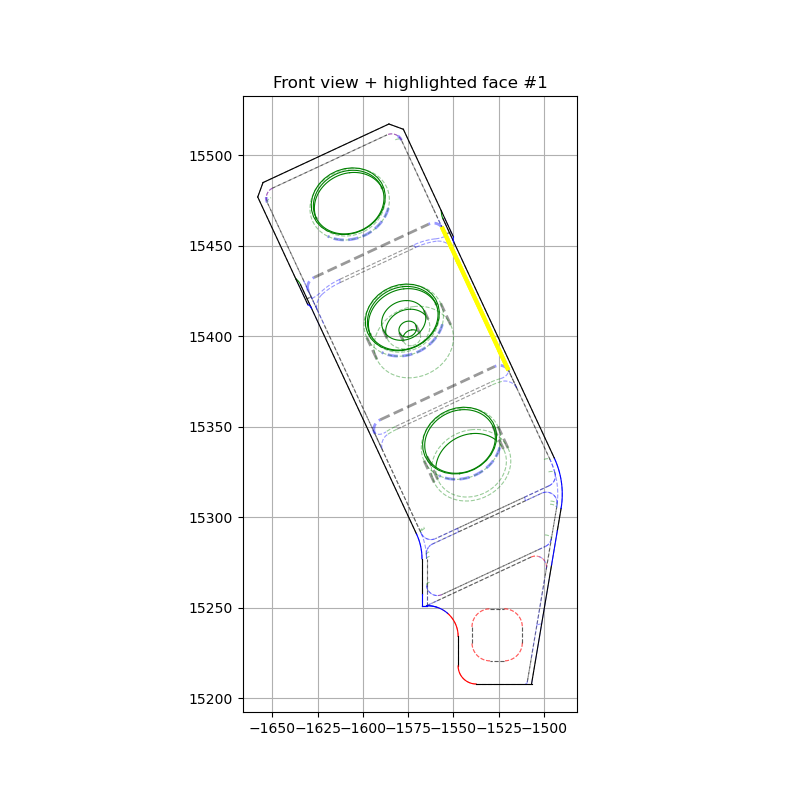

In [18]:
# 1. Строим HLR и получаем ax2, который использовался при проекции
projection, ax2_view = build_hlr_projection(
    shape,
    view_dir=(0, 0, -1),
    up_dir=(0, 1, 0),
)

visible         = projection["visible"]
hidden          = projection["hidden"]
outline_visible = projection["outline_visible"]
outline_hidden  = projection["outline_hidden"]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal", "box")

# Рисуем HLR, уже в его нативных координатах (X,Y)
draw_hlr_compound_by_type(ax, outline_hidden,  visible=False, is_outline=True)
draw_hlr_compound_by_type(ax, hidden,          visible=False, is_outline=False)
draw_hlr_compound_by_type(ax, outline_visible, visible=True,  is_outline=True)
draw_hlr_compound_by_type(ax, visible,         visible=True,  is_outline=False)

# 2. Берём грань по индексу
face_index = 1  # или любой из твоих visible_faces
face = topods.Face(multi_vis.face_map.FindKey(face_index))

# 3. Подсветка грани: она проектируется в ту же плоскость вида
highlight_face_on_view(ax, face, ax2_view, color="yellow", linewidth=3.0)

ax.set_title(f"Front view + highlighted face #{face_index}")
ax.grid(True)
plt.show()

In [19]:
from dataclasses import dataclass
from typing import Dict, List, Tuple

from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TopExp import topexp as TopExp
from OCC.Core.TopAbs import TopAbs_VERTEX, TopAbs_EDGE
from OCC.Core.TopTools import TopTools_IndexedMapOfShape
from OCC.Core.TopoDS import TopoDS_Shape, TopoDS_Vertex, TopoDS_Edge
from OCC.Core.BRep import BRep_Tool
from OCC.Core.gp import gp_Vec, gp_Pnt, gp_Ax2
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.GeomAbs import GeomAbs_Line


# --- общий helper для размеров index-map'ов (разные версии pythonocc) ---

def _map_extent(m) -> int:
    if hasattr(m, "Extent"):
        return m.Extent()
    if hasattr(m, "Size"):
        return m.Size()
    n = 0
    try:
        while True:
            n += 1
            m.FindKey(n)
    except Exception:
        pass
    return n


# --- проекция 3D -> 2D для исходной геометрии (faces/edges/vertices) ---

def project_point_to_view_2d(pnt: gp_Pnt, ax2: gp_Ax2) -> Tuple[float, float]:
    """
    3D → 2D в координатах вида:
      ξ  вдоль XDirection()
      η  вдоль YDirection()
    Это мы используем для ПРОЕКЦИИ ИСХОДНОГО SHAPE (faces/edges/vertices)
    в ту же плоскость, в которой HLR уже живёт.
    """
    origin = ax2.Location()
    vx = gp_Vec(ax2.XDirection())
    vy = gp_Vec(ax2.YDirection())
    v = gp_Vec(origin, pnt)
    xi = vx.Dot(v)
    eta = vy.Dot(v)
    return xi, eta


# --- структуры для хранения аналитического вида ---

@dataclass
class ProjectedVertex2D:
    index: int            # индекс вершины в vertex_map (1..N)
    x: float
    y: float
    vertex: TopoDS_Vertex


@dataclass
class ProjectedEdge2D:
    index: int            # индекс ребра в edge_map (1..M)
    points: List[Tuple[float, float]]
    edge: TopoDS_Edge


# --- сбор всех вершин в виде ---

def collect_projected_vertices(shape: TopoDS_Shape, view_ax2: gp_Ax2) -> Tuple[TopTools_IndexedMapOfShape, Dict[int, ProjectedVertex2D]]:
    """
    Собирает все вершины shape и их проекции на плоскость вида.

    Возвращает:
      vertex_map: IndexedMapOfShape (все вершины, индексы 1..N)
      proj_vertices: dict[index -> ProjectedVertex2D]
    """
    vertex_map = TopTools_IndexedMapOfShape()
    TopExp.MapShapes(shape, TopAbs_VERTEX, vertex_map)

    proj_vertices: Dict[int, ProjectedVertex2D] = {}

    n_vertices = _map_extent(vertex_map)
    for idx in range(1, n_vertices + 1):
        vtx = topods.Vertex(vertex_map.FindKey(idx))
        p3d = BRep_Tool.Pnt(vtx)
        x, y = project_point_to_view_2d(p3d, view_ax2)
        proj_vertices[idx] = ProjectedVertex2D(
            index=idx,
            x=x,
            y=y,
            vertex=vtx,
        )

    return vertex_map, proj_vertices

def sample_edge_2d_from_shape(edge: TopoDS_Edge, ax2: gp_Ax2, n_samples: int = 32) -> List[Tuple[float, float]]:
    """
    Семплирует ребро ИСХОДНОГО shape (а не HLR-результат)
    и возвращает точки в координатах вида (ξ,η).
    """
    pts_2d: List[Tuple[float, float]] = []

    try:
        bac = BRepAdaptor_Curve(edge)
    except Exception:
        return pts_2d

    try:
        first = bac.FirstParameter()
        last = bac.LastParameter()
    except Exception:
        return pts_2d

    if last <= first:
        return pts_2d

    if bac.GetType() == GeomAbs_Line:
        params = [first, last]
    else:
        params = [first + (last - first) * i / (n_samples - 1) for i in range(n_samples)]

    for u in params:
        try:
            p3d = bac.Value(u)
        except Exception:
            continue
        x, y = project_point_to_view_2d(p3d, ax2)
        pts_2d.append((x, y))

    return pts_2d


def collect_projected_edges(shape: TopoDS_Shape, view_ax2: gp_Ax2, n_samples: int = 32) -> Tuple[TopTools_IndexedMapOfShape, Dict[int, ProjectedEdge2D]]:
    """
    Собирает все рёбра shape и их проекции на плоскость вида.

    Возвращает:
      edge_map: IndexedMapOfShape (все rёбра, индексы 1..M)
      proj_edges: dict[index -> ProjectedEdge2D]
    """
    edge_map = TopTools_IndexedMapOfShape()
    TopExp.MapShapes(shape, TopAbs_EDGE, edge_map)

    proj_edges: Dict[int, ProjectedEdge2D] = {}

    n_edges = _map_extent(edge_map)
    for idx in range(1, n_edges + 1):
        edge = topods.Edge(edge_map.FindKey(idx))
        pts = sample_edge_2d_from_shape(edge, view_ax2, n_samples=n_samples)
        proj_edges[idx] = ProjectedEdge2D(
            index=idx,
            points=pts,
            edge=edge,
        )

    return edge_map, proj_edges

import matplotlib.pyplot as plt


def highlight_edge_on_view(ax,
                           proj_edges: Dict[int, ProjectedEdge2D],
                           edge_index: int,
                           color: str = "cyan",
                           linewidth: float = 2.0):
    """
    Подсветить одно ребро по индексу edge_index (индекс из edge_map).
    """
    pe = proj_edges.get(edge_index)
    if pe is None:
        print(f"[highlight_edge_on_view] нет ребра с индексом {edge_index}")
        return

    pts = pe.points
    if len(pts) < 2:
        return

    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    ax.plot(xs, ys, color=color, linewidth=linewidth, zorder=15)


def highlight_vertex_on_view(ax,
                             proj_vertices: Dict[int, ProjectedVertex2D],
                             vertex_index: int,
                             color: str = "yellow",
                             size: float = 40.0):
    """
    Подсветить вершину по индексу vertex_index (индекс из vertex_map).
    """
    pv = proj_vertices.get(vertex_index)
    if pv is None:
        print(f"[highlight_vertex_on_view] нет вершины с индексом {vertex_index}")
        return

    ax.scatter([pv.x], [pv.y],
               s=size,
               color=color,
               edgecolors="black",
               linewidths=0.5,
               zorder=20)

Всего вершин: 244
Всего рёбер: 393


c:\Users\dreck\miniconda3\envs\oss_env\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


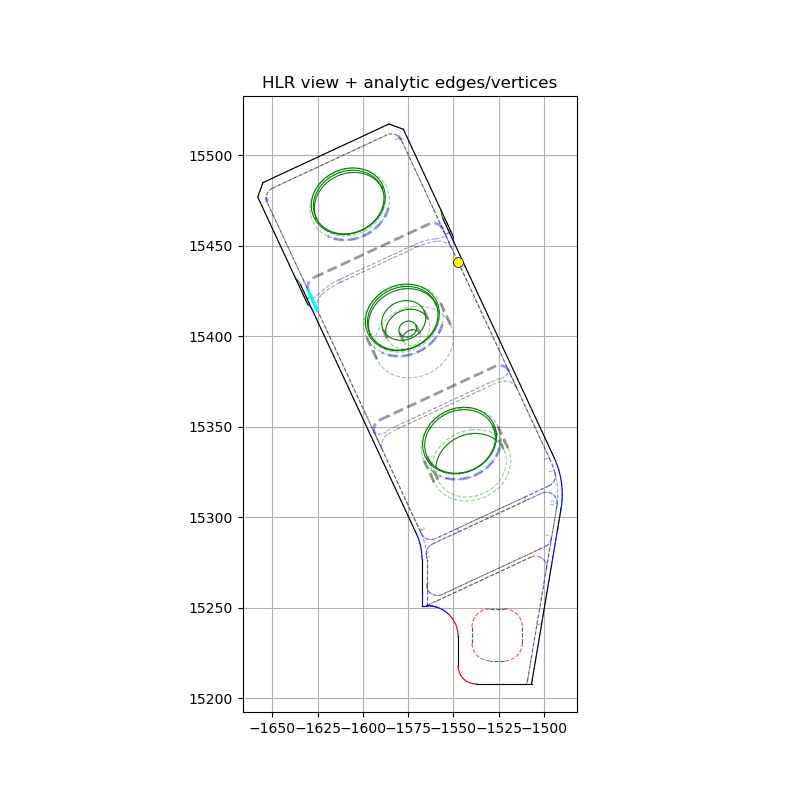

In [ ]:
from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Ax2

# 1. HLR-проекция + система координат вида
projection, ax2_view = build_hlr_projection(
    shape,
    view_dir=(0, 0, -1),
    up_dir=(0, 1, 0),
)

visible         = projection["visible"]
hidden          = projection["hidden"]
outline_visible = projection["outline_visible"]
outline_hidden  = projection["outline_hidden"]

# 2. Собираем аналитический вид: вершины + рёбра исходного shape
vertex_map, proj_vertices = collect_projected_vertices(shape, ax2_view)
edge_map, proj_edges = collect_projected_edges(shape, ax2_view, n_samples=32)

print("Всего вершин:", _map_extent(vertex_map))
print("Всего рёбер:", _map_extent(edge_map))

# 3. Рисуем HLR-вид
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal", "box")

draw_hlr_compound_by_type(ax, outline_hidden,  visible=False, is_outline=True)
draw_hlr_compound_by_type(ax, hidden,          visible=False, is_outline=False)
draw_hlr_compound_by_type(ax, outline_visible, visible=True,  is_outline=True)
draw_hlr_compound_by_type(ax, visible,         visible=True,  is_outline=False)

ax.grid(True)
ax.set_title("HLR view + analytic edges/vertices")

# 4. Подсветим пару рёбер и вершин
edge_idx = 10      # например, десятое ребро
vertex_idx = 5     # и пятая вершина

highlight_edge_on_view(ax, proj_edges, edge_idx, color="cyan", linewidth=2.5)
highlight_vertex_on_view(ax, proj_vertices, vertex_idx, color="yellow", size=50.0)

plt.show()
